# MPAS-Ocean time series

## Ten-year periods (1947-1956, 1997-2006)

LR (`60to30E2r2`) and HR (`18to6v3`) CORE-forced 20-21st century simulations (Cycle 1).

***

In [1]:
import numpy as np
import xarray as xr
import sys
from dateutil.parser import parse
from matplotlib import pyplot as plt, ticker
from fastjmd95 import rho

# Import modules from path
sys.path.append('../modules/')
import visualizationtools as viz

# Set plot font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

## Load results

Define paths, parameters and load aggregated netCDF files. Files were produced using [build_mpas_wmtrtimeseries.py](https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/modules/build_mpas_wmtrtimeseries.py).

In [2]:
# Path, meshes and timeranges
resultspath = '/pscratch/sd/b/bmoorema/results/aggregated/timeseries/'
meshes = ['EC30to60E2r2', 'oRRS18to6v3']
timeranges = [
    ('1947 Jan 1', '1956 Dec 31'),
    ('1997 Jan 1', '2006 Dec 31'),
]
timeranges = [[parse(t) for t in trange] for trange in timeranges]

# Loop though meshes and timeranges
ds = {}
for mesh in meshes:
        
    # Construct strings and load 2D fields via xarray
    fn = resultspath + '20210421_sim7_CORE_' + mesh + '.mpastimeseries_wmt_19470101_20061201.nc'
    ds[mesh] = xr.open_dataset(fn)

***

### Sigma space curves

**Total WMTF (all seasons)**

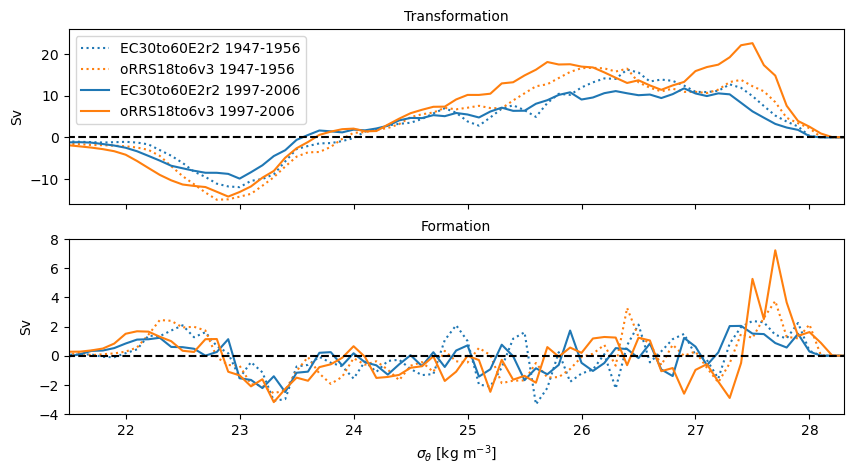

In [3]:
# Plot total WMT, all months
ylims = [(-16, 26), (-4, 8)]
fig, axs = viz.plot_wmt_sigma(ds, 'total', timeranges, ylims=ylims)

**Heat component of WMTF (all seasons)**

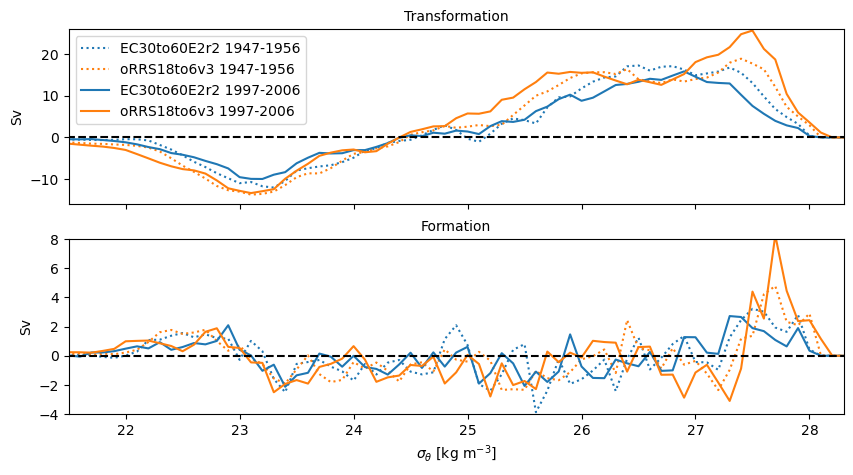

In [4]:
# Plot WMT heat component, all months
fig, axs = viz.plot_wmt_sigma(ds, 'heat', timeranges, ylims=ylims)

**Salt component of WMTF (all seasons)**

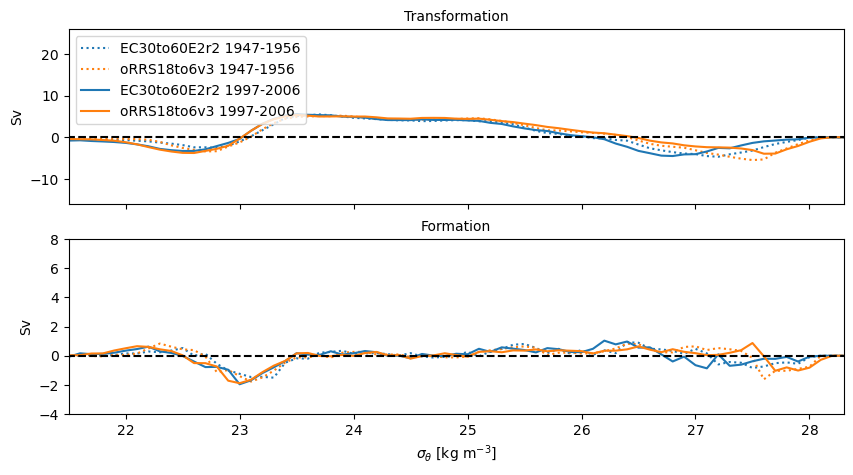

In [5]:
# Plot WMT heat component, all months
fig, axs = viz.plot_wmt_sigma(ds, 'salt', timeranges, ylims=ylims)

**Total WMTF (DJF)**

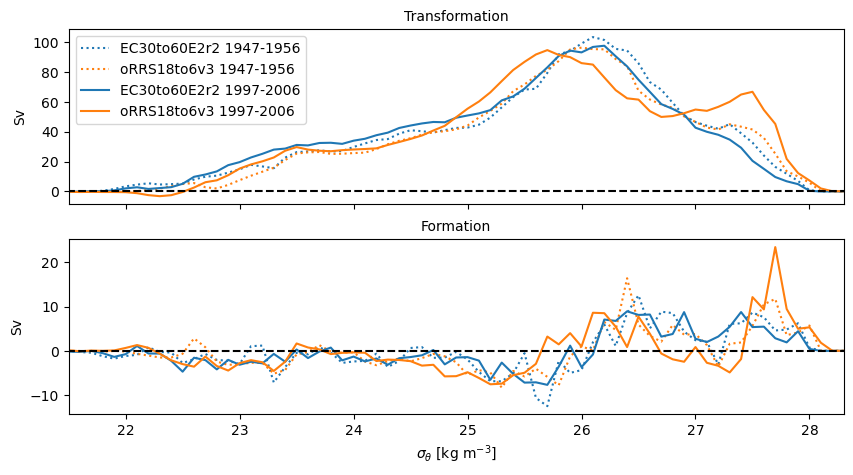

In [6]:
# Plot total WMT, DJF
fig, axs = viz.plot_wmt_sigma(ds, 'total', timeranges, months=[12, 1, 2])

***

### Hoffmueller plots

**Total transformation**

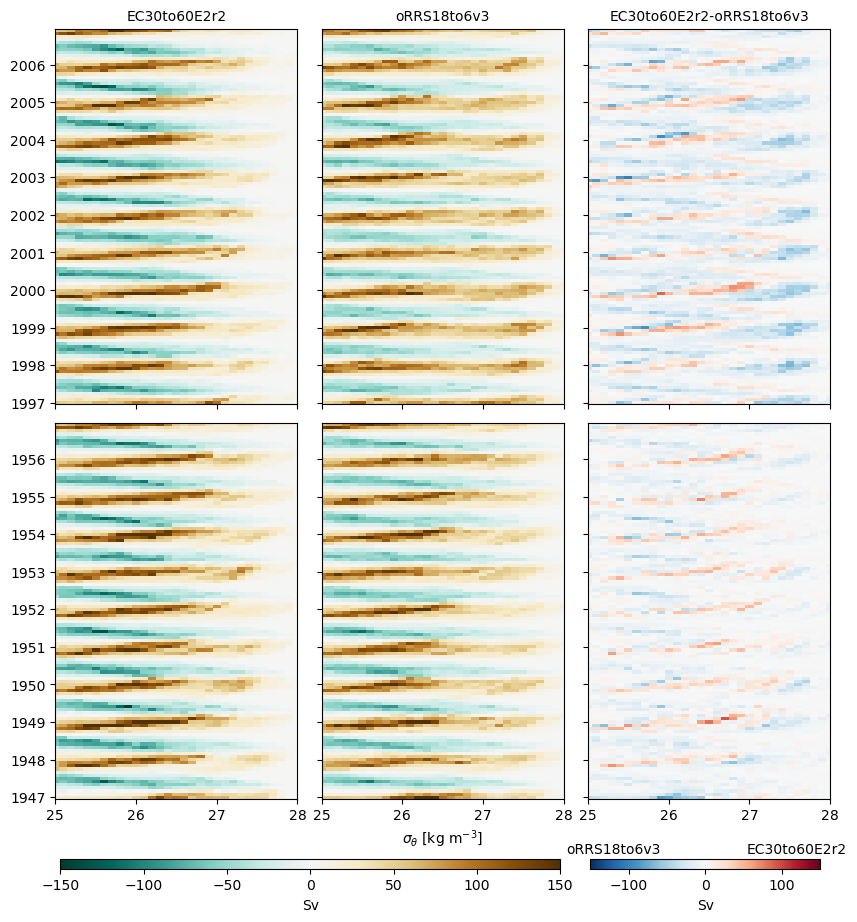

In [7]:
# Plot total transformation
fig, axs = viz.plot_wmt_hoffmueller(ds, 'totalTrans', timeranges, clim=150)

**Total formation**

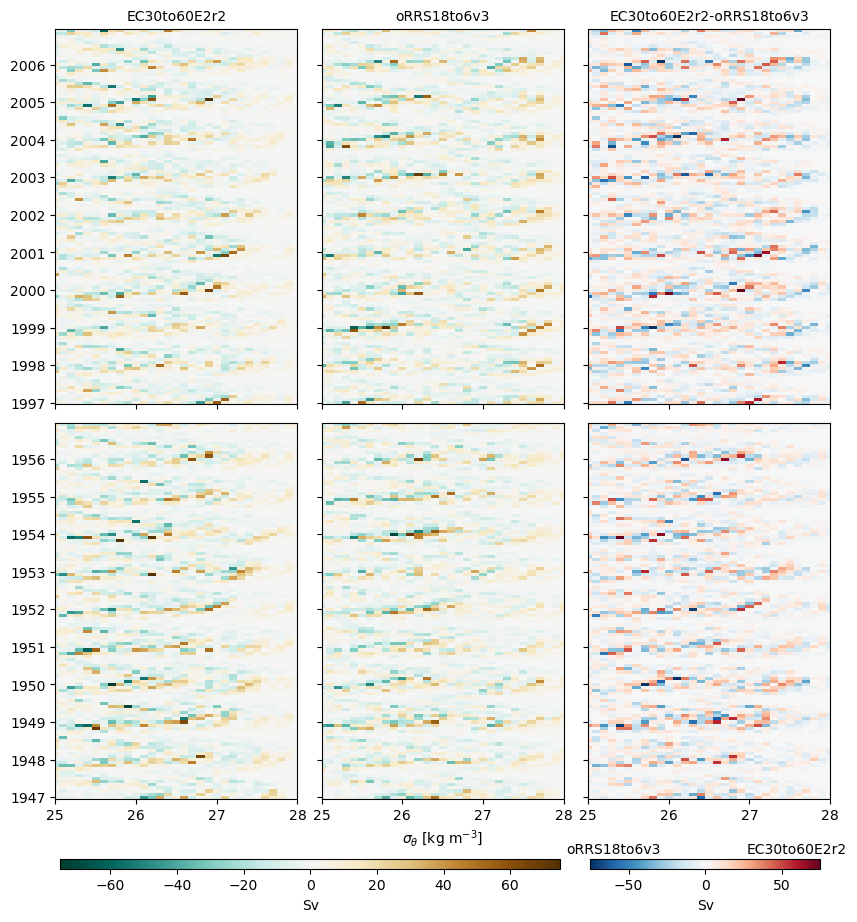

In [8]:
# Plot total formation
fig, axs = viz.plot_wmt_hoffmueller(ds, 'totalForm', timeranges)

***

### Time series

**STMW (18$^{\circ}$ water) Formation**

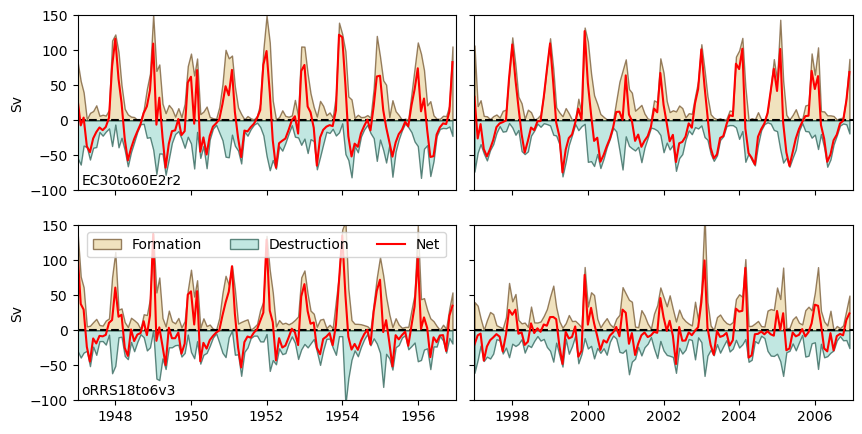

In [9]:
fig, axs = viz.plot_wmt_timeseries(ds, 'totalForm', timeranges, [26.2, 27])

**SPMW Formation**

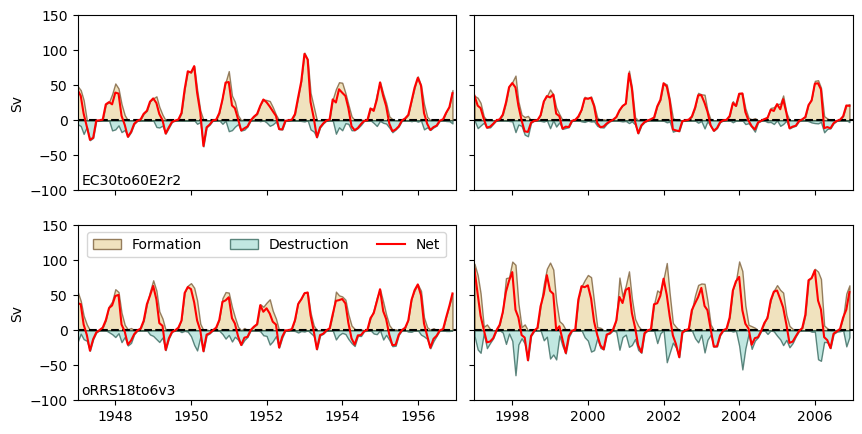

In [10]:
fig, axs = viz.plot_wmt_timeseries(ds, 'totalForm', timeranges, [27.3, 28])

***

### Correlations

**SPMW vs Temperature (all seasons)**

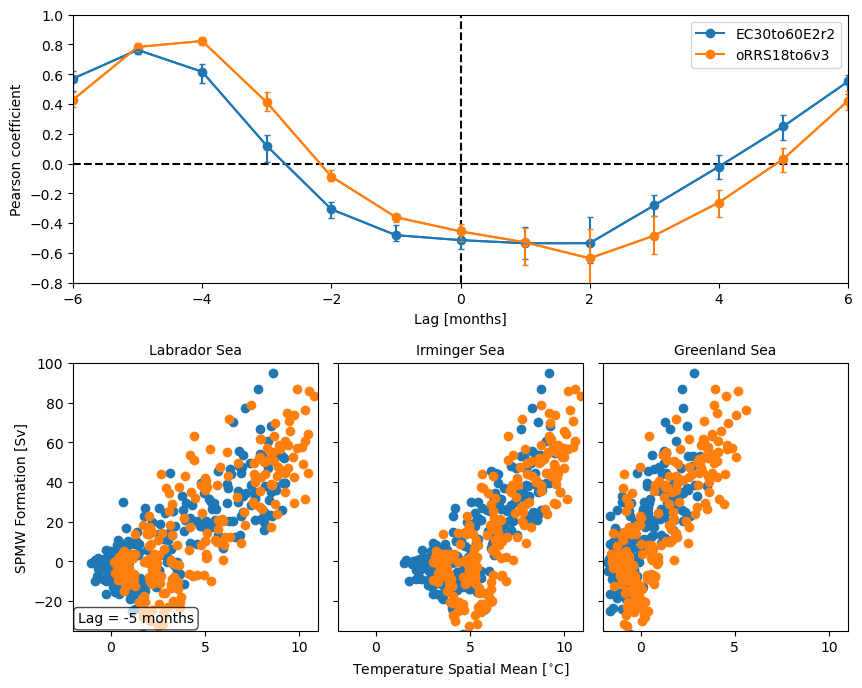

In [11]:
# Define variables and regions
varnames, sigmabins = ['temperature', 'totalForm'], [27.3, 28]
lims, xlabel = [-2, 11, -35, 100], 'Temperature Spatial Mean [$^{\circ}$C]'
regions = [['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'Rockall Trench', 'Norwegian Sea', 'Greenland Sea']]
viz.plot_correlation_multipanel(ds, varnames, sigmabins, regions, xlabel, lims, lag=-5)

**SPMW vs Salinity (all seasons)**

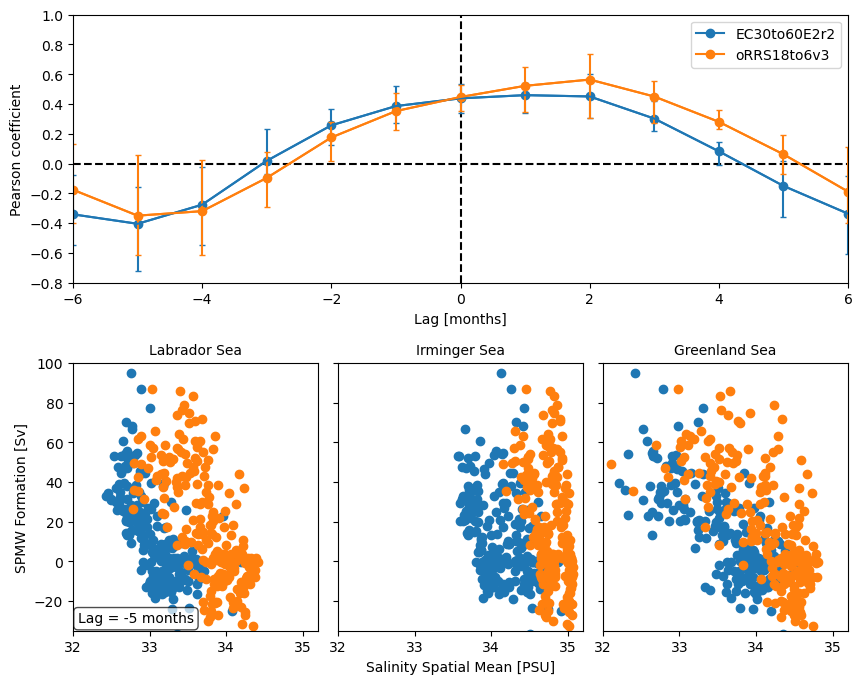

In [12]:
# Define variables and regions
varnames, sigmabins = ['salinity', 'totalForm'], [27.3, 28]
lims, xlabel = [32, 35.2, -35, 100], 'Salinity Spatial Mean [PSU]'
regions = [['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'Rockall Trench', 'Norwegian Sea', 'Greenland Sea']]
viz.plot_correlation_multipanel(ds, varnames, sigmabins, regions, xlabel, lims, lag=-5)

**SPMW vs MLD (all seasons)**

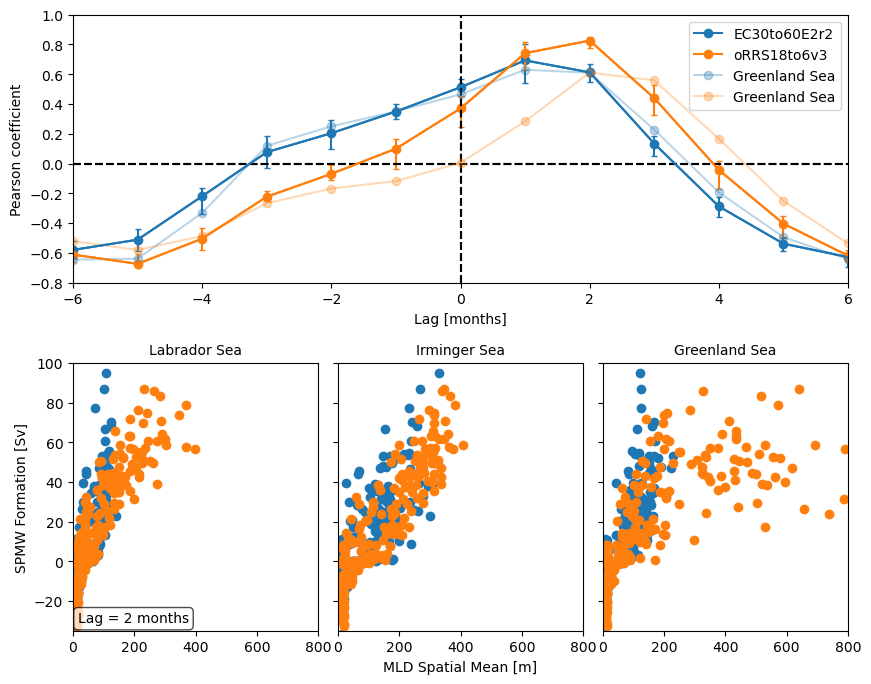

In [13]:
# Define variables and regions
varnames, sigmabins = ['dThreshMLD', 'totalForm'], [27.3, 28]
lims, xlabel = [0, 800, -35, 100], 'MLD Spatial Mean [m]'
regions = [['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'Rockall Trench', 'Norwegian Sea'], ['Greenland Sea']]
viz.plot_correlation_multipanel(ds, varnames, sigmabins, regions, xlabel, lims, lag=2)

**SPMW vs $v$-Meridional (all seasons)**

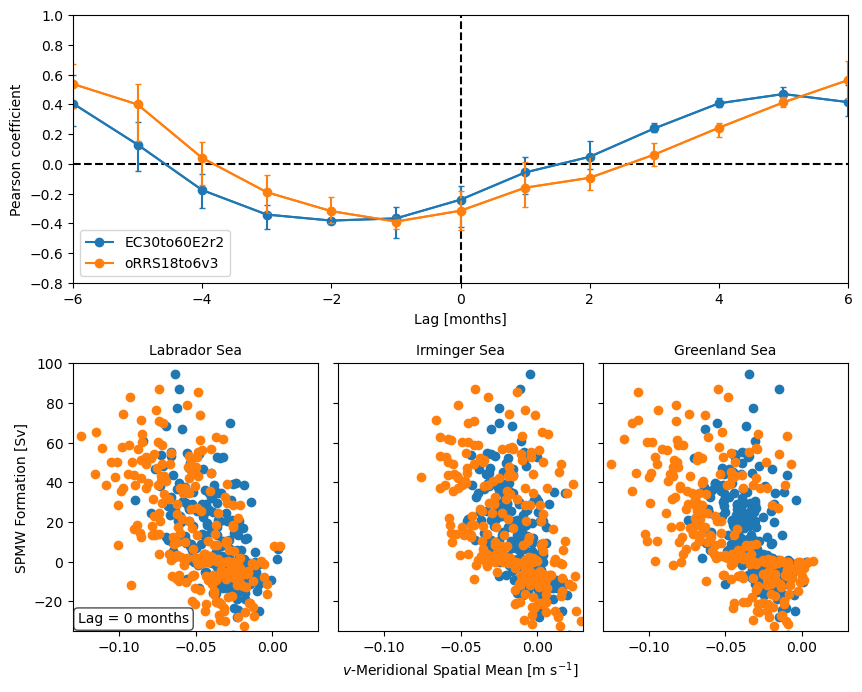

In [14]:
# Define variables and regions
varnames, sigmabins = ['velocityMeridional', 'totalForm'], [27.3, 28]
lims, xlabel = [-0.13, 0.03, -35, 100], '$v$-Meridional Spatial Mean [m s$^{-1}$]'
regions = [['Labrador Sea', 'Irminger Sea', 'Greenland Sea']]
viz.plot_correlation_multipanel(ds, varnames, sigmabins, regions, xlabel, lims)

***

### Summary figure

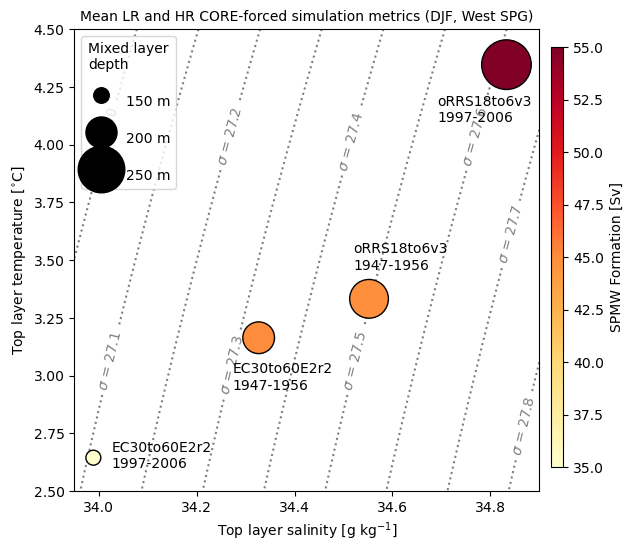

In [15]:
# Summary plot parameters
regions = ['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'Greenland Sea']
varnames = ['salinity', 'temperature', 'dThreshMLD', 'totalForm']
months, sigmarange = [12, 1, 2], [27.3, 28]

# Loop through meshes and timeranges
variables, labels = {name: [] for name in varnames}, []
regions = np.array(regions, dtype=bytes)
for mesh in ds:
    for timerange in timeranges:
        
        # Slice and average over regions and times
        ds_slc = ds[mesh].sel(time=slice(*timerange), regionNames=regions, depths=0).mean(dim='regionNames')
        ds_slc = ds_slc.sel(time=ds_slc.time.dt.month.isin(months)).mean(dim='time')
    
        # Extract mean variables (integrate formation over sigma range)
        for name in varnames:
            da = ds_slc[name]
            if name == 'totalForm':
                da = da.sel(sigmaBins=slice(*sigmarange)).sum(dim='sigmaBins')
            variables[name].append(float(da))
        
        # Append label
        labels.append(mesh + '\n' + '-'.join(str(t.year) for t in timerange))
            
# Stack meshes and timeranges and scale MLD for plotting
S, T, MLD, M = [np.array(variables[name]) for name in varnames]
MLD = (MLD - 100)**2 / 20

# Make figure and format
fig, ax = plt.subplots(figsize=(6, 6))
xlim, ylim = [33.95, 34.9], [2.5, 4.5]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Top layer salinity [g kg$^{-1}$]')
ax.set_ylabel('Top layer temperature [$^{\circ}$C]')
ax.set_title('Mean LR and HR CORE-forced simulation metrics (DJF, West SPG)')

# Plot sigma contours and T,S,MLD,Formation scatter
Sgrid, Tgrid = np.linspace(*xlim, 100), np.linspace(*ylim, 100)
sigma = rho(*np.meshgrid(Sgrid, Tgrid), 0) - 1000
c = ax.contour(Sgrid, Tgrid, sigma, levels=np.arange(27, 27.8, 0.1), colors='gray', linestyles=':', zorder=-10)
sc = ax.scatter(S, T, MLD, M, vmin=35, vmax=55, cmap='YlOrRd', ec='k')

# Add point labels
positions = [(0.34, 0.22), (0.08, 0.05), (0.6, 0.48), (0.78, 0.8)]
for label, pos in zip(labels, positions):
    ax.text(*pos, label, transform=ax.transAxes)

# Add MLD legend
elements = sc.legend_elements(
    "sizes", fmt="\n{x:d} m",
    num=ticker.FixedLocator(range(150, 251, 50)),
    func=lambda x: (x*20)**(1/2)+100, # MLD scale
)
ax.legend(*elements, title='Mixed layer\ndepth')

# Add colorbar and contour labels
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, label='SPMW Formation [Sv]')
ax.clabel(c, fmt='$\sigma$ = %.1f')
plt.show()